## Face Mask Detection

### Step 1: Import the necessary packages

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

### Step 2: Define paths for dataset, plot and model

In [2]:
dataset_path = '/content/drive/MyDrive/Face Mask Detection/dataset'
plot_path = "plot.png"
model_path = "mask_detector.model"

### Step 3: Initialize the initial learning rate, number of epochs to train for, and batch size

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

### Step 4: Load and Preprocess the images

In [4]:
from PIL import Image
imagePaths = list(paths.list_images(dataset_path))
data = []
labels = []

for imagePath in imagePaths:
  label = imagePath.split(os.path.sep)[-2]

  # load the image and convert it to RGBA if needed
  image = Image.open(imagePath).convert('RGB')  # Convert to RGB
  image = image.resize((224, 224))  # Resize the image
  image = img_to_array(image)  # Convert to array
  image = preprocess_input(image)  # Preprocess the image

  # Append the image and label
  data.append(image)
  labels.append(label)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### Step 5: Convert data and labels to Numpy arrays:

In [5]:
data = np.array(data, dtype='float32')
labels = np.array(labels)

### Step 6: Perform one-hot encoding on the labels

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

### Step 7: Split the data into training and testing sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.20,
                                                    stratify=labels, random_state=42)

### Step 8: Data Augmentation

In [8]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

### Step 9: Load the MobileNetV2 network

In [9]:
baseModel = MobileNetV2(weights='imagenet', include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))
baseModel.summary()

<ipython-input-9-ed321e091143>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights='imagenet', include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Step 10: Construct the head of the model

In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name='flatten')(headModel)
headModel = Dense(128, activation='relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

### Step 11: Place the head FC model on top of the base Model

In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,210 (9.24 MB)

 Trainable params: 2,388,098 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

### Step 12: Freeze the layers of the base model

In [13]:
for layer in baseModel.layers:
  layer.trainable = False

### Step 13: Compile the model

In [14]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

### Step 14: Train the head of the network

In [15]:
print(X_test.shape)
print(y_test.shape)

(819, 224, 224, 3)
(819, 2)


In [17]:
History = model.fit(
    aug.flow(X_train, y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, y_test),
    epochs=EPOCHS)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


102/102 ━━━━━━━━━━━━━━━━━━━━ 44s 399ms/step - accuracy: 0.9656 - loss: 0.1487 - val_accuracy: 0.9841 - val_loss: 0.0663
Epoch 2/20
  1/102 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9688 - loss: 0.0827

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9688 - loss: 0.0827 - val_accuracy: 0.9841 - val_loss: 0.0660
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 74s 346ms/step - accuracy: 0.9669 - loss: 0.0960 - val_accuracy: 0.9878 - val_loss: 0.0529
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0443 - val_accuracy: 0.9878 - val_loss: 0.0529
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 40s 356ms/step - accuracy: 0.9768 - loss: 0.0772 - val_accuracy: 0.9902 - val_loss: 0.0462
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9062 - loss: 0.2361 - val_accuracy: 0.9902 - val_loss: 0.0461
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 355ms/step - accuracy: 0.9809 - loss: 0.0685 - val_accuracy: 0.9902 - val_loss: 0.0434
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9688 - loss: 0.0873 - val_accuracy: 0.9902 - val_loss: 0.0430
Epoch 9/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 39s 361ms/step - accuracy: 0.9809 - loss: 0.0577 - val_accuracy

### Step 15: Evaluate the network

In [35]:
# Predict the class probabilities for the test data
pred_probs = model.predict(X_test, batch_size=BS)

# Convert the predicted probabilities to class indices
predIdxs = np.argmax(pred_probs, axis=1)

# Convert the one-hot encoded true labels to class indices
y_test_labels = np.argmax(y_test, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


### Step 16: Save the mask detector model

In [63]:
model.save('face_detector.h5')

### Step 17: Plot the training loss and accuracy

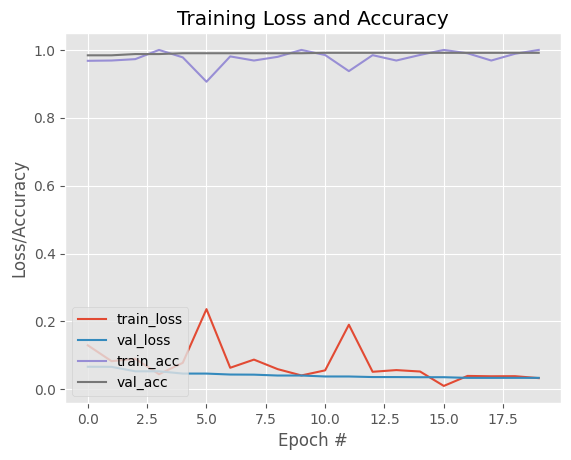

In [41]:
N = EPOCHS
plt.style.use('ggplot')
plt.figure()
plt.plot(np.arange(0, N), History.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), History.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), History.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), History.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(plot_path)
plt.show()